In [3]:
%load_ext autoreload
%autoreload 2

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import yaml

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# local imports
from hydra import compose, initialize
from src.data_processing.preprocessing.pandas_preprocessors import *
from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe




In [54]:
with open('/Users/mds8301/Development/ENIGMA/modeling/experiments/conf/local_config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
DATA_PATH = config['local_config']['data_path']

In [55]:
pd.read_parquet(DATA_PATH)


,mouse_id,day,event,sensor,time,trial,signal,action,latency,sex,learning_phase,trial_count
0,12,5,cue,D2,-25.000000,0,-0.155359,escape,0.00,F,0,115
1,12,5,cue,D2,-24.901531,0,-0.420553,escape,0.00,F,0,115
2,12,5,cue,D2,-24.803064,0,-1.592294,escape,0.00,F,0,115
3,12,5,cue,D2,-24.704596,0,-1.268734,escape,0.00,F,0,115
4,12,5,cue,D2,-24.606127,0,-0.210176,escape,0.00,F,0,115
...,...,...,...,...,...,...,...,...,...,...,...,...
5860105,1,4,escape,D1,19.606127,1,0.299603,avoid,7.54,F,0,87
5860106,1,4,escape,D1,19.704596,1,-0.249408,avoid,7.54,F,0,87
5860107,1,4,escape,D1,19.803064,1,-0.486369,avoid,7.54,F,0,87
5860108,1,4,escape,D1,19.901531,1,-0.146374,avoid,7.54,F,0,87


In [56]:
def df_pipeline(df):
    '''pandas preprocessing specific to this experiment'''
    drop_columns = ["action", "sex", "trial_count", "trial"]
    df_ = (
        df
        .query("sensor=='DA'")
        .pipe(calculate_max_min_signal)
        .pipe(calculate_percent_avoid)
        .drop(columns=drop_columns)
        .pipe(expand_df)
        .drop(columns=['mouse_id', 'day'])
    )
    return df_

PROCESSOR_PIPE = (ClassifierPipe(DATA_PATH)
                    .read_raw_data()
                    .pandas_pipe(df_pipeline)
                    .split_by_ratio(target='ratio_avoid')
                    .transform_data()
                    )
# ids = assign_ids(df)
PROCESSOR_PIPE.processed_data


,ratio_avoid,neg_signal_trapz_DA_avoid,neg_signal_trapz_DA_cue,neg_signal_trapz_DA_escape,neg_signal_trapz_DA_shock,pos_signal_trapz_DA_avoid,pos_signal_trapz_DA_cue,pos_signal_trapz_DA_escape,pos_signal_trapz_DA_shock,signal_max_DA_avoid,...,signal_max_DA_escape,signal_max_DA_shock,signal_min_DA_avoid,signal_min_DA_cue,signal_min_DA_escape,signal_min_DA_shock,signal_trapz_DA_avoid,signal_trapz_DA_cue,signal_trapz_DA_escape,signal_trapz_DA_shock
0,0.0,-175.680374,-167.158646,-171.241150,-174.943573,159.930649,165.179321,173.003891,171.078247,3.577325,...,4.986666,4.798352,-2.163916,-2.174700,-2.351609,-2.389435,-15.749731,-1.979335,1.762733,-3.865334
1,0.0,-162.030914,-166.663467,-181.359558,-180.819473,181.423279,167.092072,163.724335,163.230408,4.665627,...,3.470809,3.477009,-1.792376,-1.703143,-1.758063,-1.758867,19.392359,0.428599,-17.635229,-17.589060
2,0.0,-188.438995,-188.475937,-182.854126,-181.354370,178.818436,182.002396,225.591339,228.621902,4.469812,...,4.179577,4.377404,-2.138257,-2.162860,-2.447979,-2.518370,-9.620571,-6.473549,42.737228,47.267506
3,0.0,-187.598328,-182.339111,-217.391159,-198.629608,152.694260,159.902115,273.340790,289.223145,3.964172,...,5.222464,5.002191,-2.090872,-2.109405,-2.808737,-2.584502,-34.904079,-22.436991,55.949619,90.593544
4,0.0,-156.896820,-164.152283,-235.104416,-247.854660,192.241592,199.175629,227.439316,217.697083,3.443027,...,4.747762,4.778614,-1.785133,-1.827088,-2.159111,-2.210720,35.344769,35.023357,-7.665092,-30.157568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.0,-183.375275,-180.726212,-252.993683,-252.885529,181.740265,183.750793,136.457840,137.336273,3.277046,...,3.247298,3.238914,-2.050364,-2.062605,-2.395465,-2.416087,-1.635001,3.024579,-116.535851,-115.549271
92,1.0,-192.717606,-184.584946,-268.689178,-270.515015,179.906921,177.026825,122.431038,121.545303,4.754360,...,5.420471,5.363124,-1.861220,-1.854003,-2.086705,-2.104770,-12.810680,-7.558132,-146.258148,-148.969711
93,1.0,-215.769089,-207.240372,-261.838837,-248.177307,169.799576,175.631638,120.482323,127.495354,3.300718,...,2.781533,2.833766,-2.016711,-1.951842,-1.979279,-1.932195,-45.969501,-31.608734,-141.356522,-120.681953
94,1.0,-190.794174,-195.882523,NaN,NaN,194.138947,188.402954,NaN,NaN,3.234605,...,NaN,NaN,-2.133203,-2.132184,NaN,NaN,3.344767,-7.479568,NaN,NaN


In [220]:
best_params = {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'reg_lambda': 0.5, 'subsample': 0.6000000000000001}


model = xgb.XGBRegressor(
            objective='reg:squarederror', eval_metric=['rmse', 'mae'], **best_params)
model.fit(PROCESSOR_PIPE.X_train, PROCESSOR_PIPE.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# EVALUATION


In [221]:

mse_train = mean_squared_error(PROCESSOR_PIPE.y_train, model.predict(PROCESSOR_PIPE.X_train))
mse_dev = mean_squared_error(PROCESSOR_PIPE.y_dev, model.predict(PROCESSOR_PIPE.X_dev))
mse_test = mean_squared_error(PROCESSOR_PIPE.y_test, model.predict(PROCESSOR_PIPE.X_test))
print(f" MSE for optimzied model on train is {mse_train}")
print(f" MSE for optimzied model on development test is {mse_dev}")
print(f" MSE for optimzied model on test is {mse_test}")

 MSE for optimzied model on train is 0.016799785320269923
 MSE for optimzied model on development test is 0.06600875138745692
 MSE for optimzied model on test is 0.08595767698207643


In [222]:
predicted_ratio_avoid = model.predict(PROCESSOR_PIPE.X_test)

In [223]:
def get_cols_from_pipeline(pipeline):
        return pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()

def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
        )
                
testing_df = get_df_from_pipeline(PROCESSOR_PIPE, predicted_ratio_avoid)


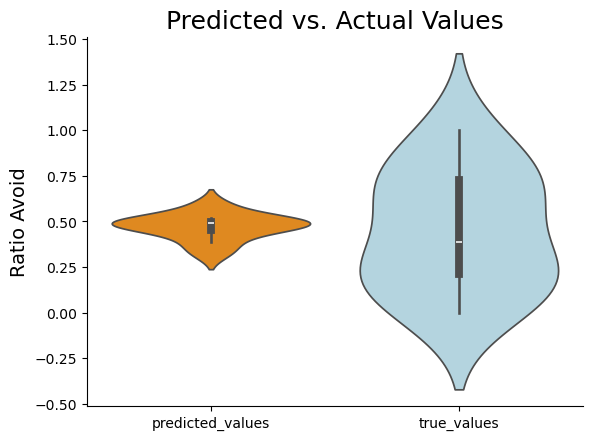

In [224]:
fig, ax = plt.subplots()
sns.violinplot(data=testing_df, x='inference_cat', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)




ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Predicted vs. Actual Values', fontsize = 18)
sns.despine()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

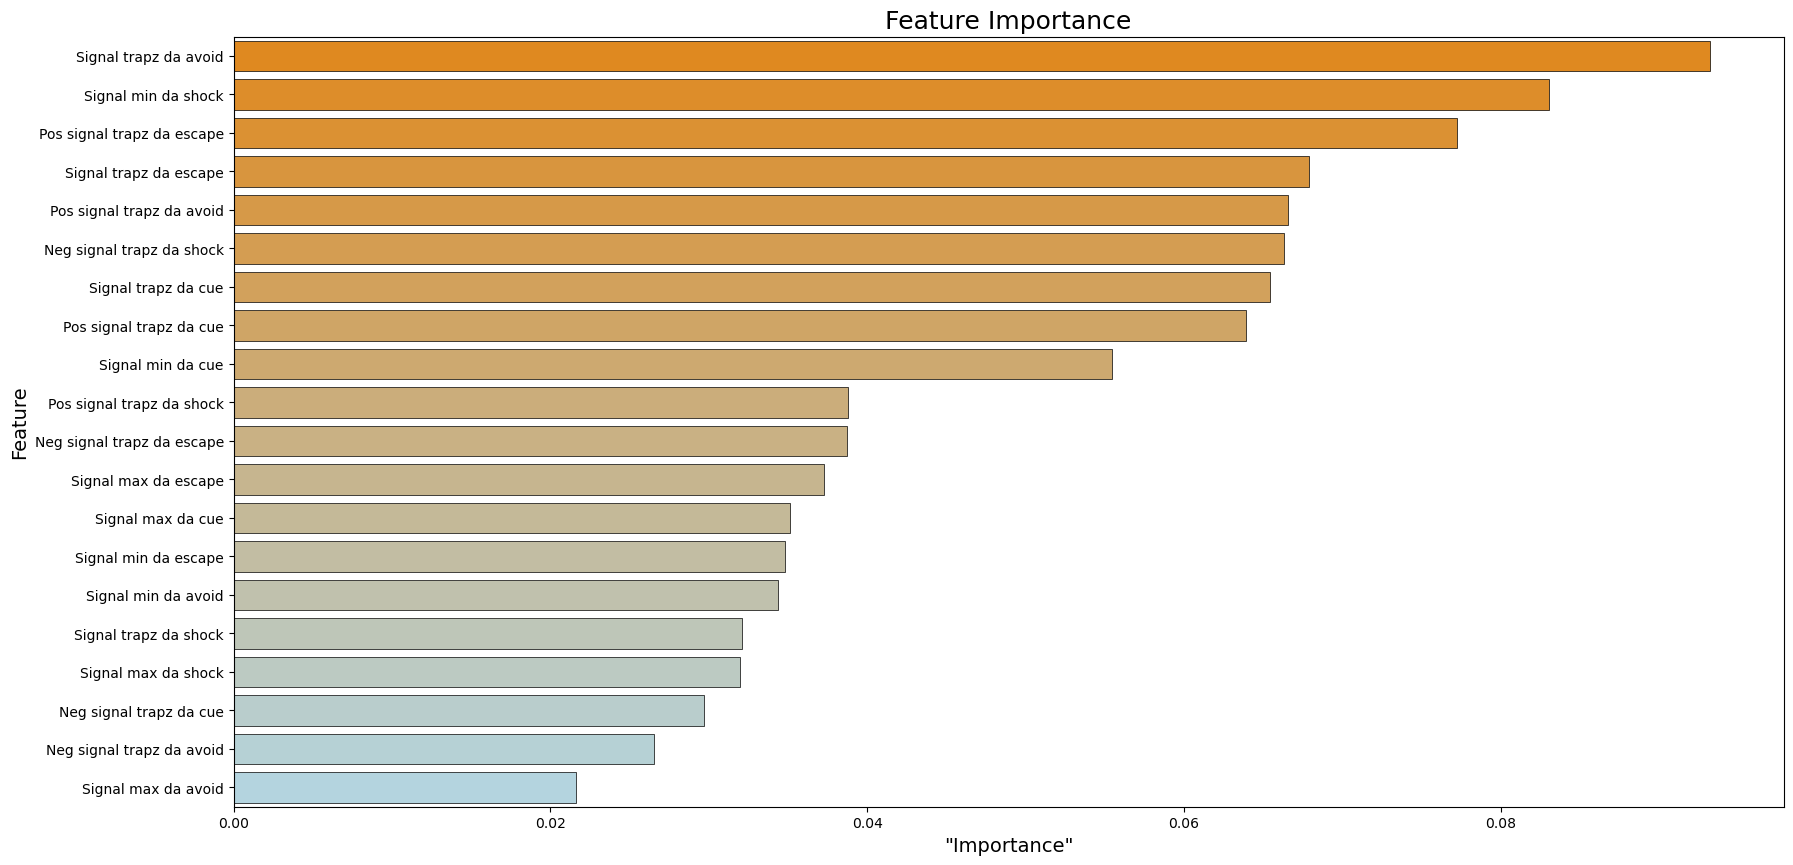

In [214]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(PROCESSOR_PIPE)
# cols_new = [col.removeprefix("sensor_event_variable_") for col in cols]
feature_importance = (
    pd.Series(
    model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
# ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)

[16:40:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


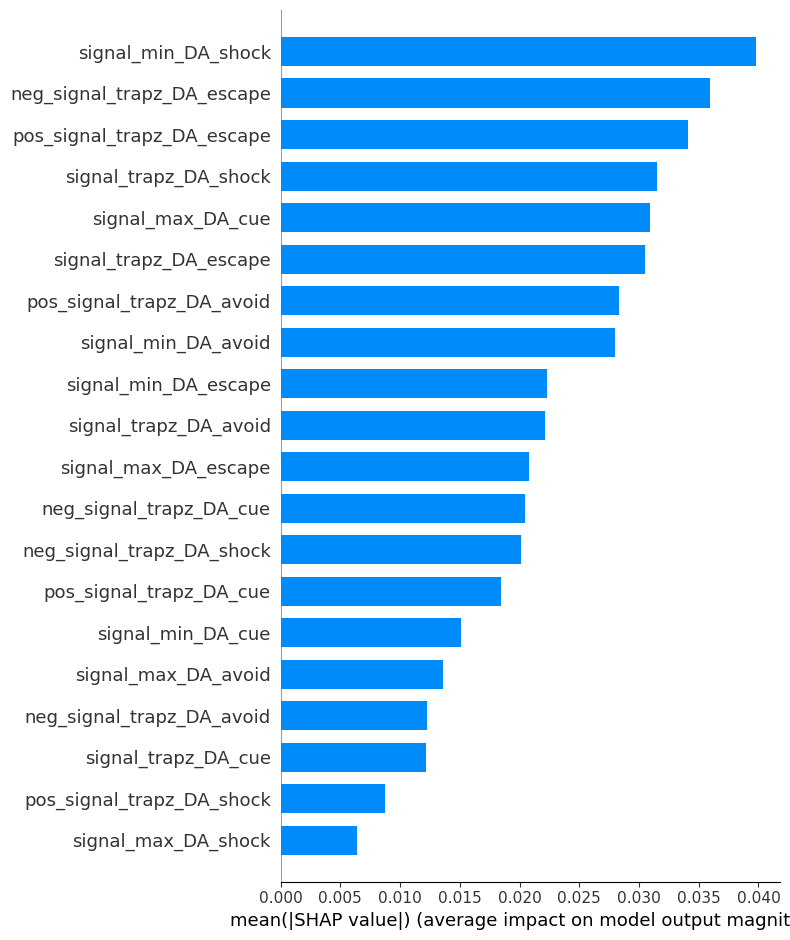

In [180]:

explainer = shap.TreeExplainer(model,PROCESSOR_PIPE.X_train)
explanation = explainer(PROCESSOR_PIPE.X_train)
explanation.feature_names = cols
shap.summary_plot(explanation, plot_type="bar")

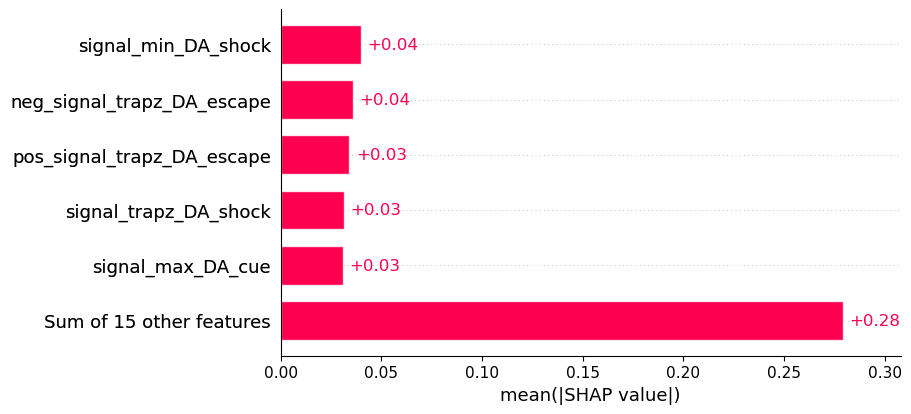

In [181]:
shap.plots.bar(explanation, max_display=6)



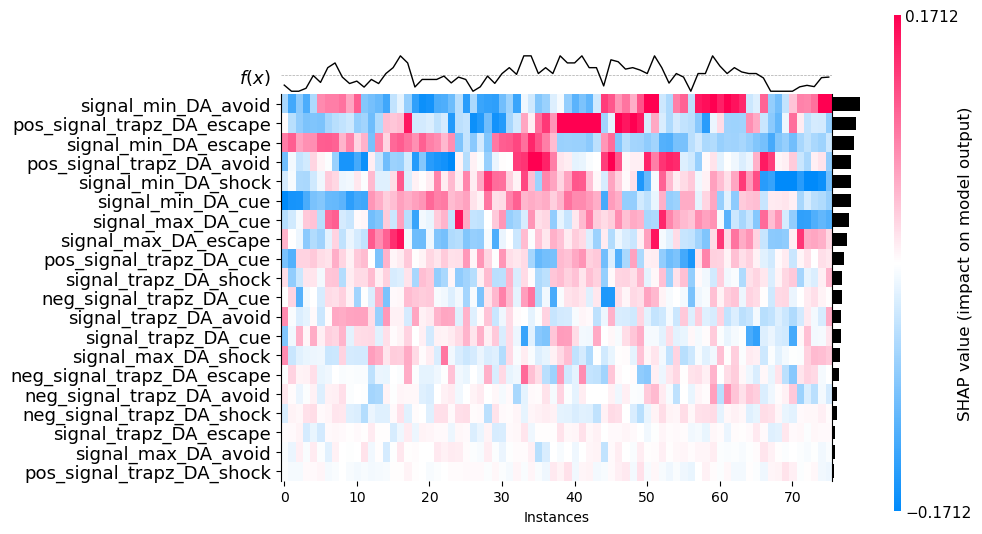

In [163]:
shap.plots.heatmap(explanation, max_display=20)

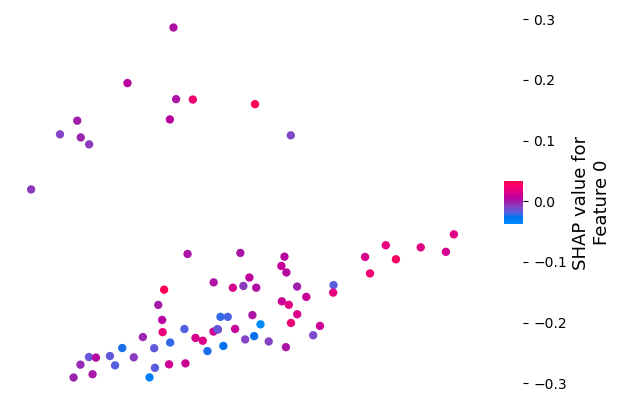

In [182]:
shap.plots.embedding(shap_values = explanation.values, ind=0)

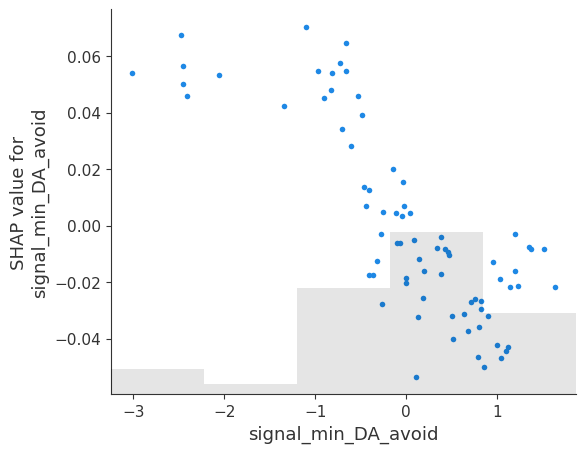

In [183]:
shap.plots.scatter(explanation[:, "signal_min_DA_avoid"])

# Keep top 4 features

In [194]:
def df_pipeline_no_cue(df):
    '''pandas preprocessing specific to this experiment'''
    drop_columns = ["action", "sex", "trial_count", "trial"]
    df_ = (
        df
        .query("sensor=='DA' and event != 'cue'")
        .pipe(calculate_max_min_signal)
        .pipe(calculate_percent_avoid)
        .drop(columns=drop_columns)
        .pipe(expand_df)
        .drop(columns=['mouse_id', 'day'])
    )
    return df_

NO_CUE_PIPE = (ClassifierPipe(DATA_PATH)
                    .read_raw_data()
                    .pandas_pipe(df_pipeline_no_cue)
                    .split_by_ratio(target='ratio_avoid')
                    .transform_data()
                    )
# ids = assign_ids(df)
NO_CUE_PIPE.processed_data

,ratio_avoid,neg_signal_trapz_DA_avoid,neg_signal_trapz_DA_escape,neg_signal_trapz_DA_shock,pos_signal_trapz_DA_avoid,pos_signal_trapz_DA_escape,pos_signal_trapz_DA_shock,signal_max_DA_avoid,signal_max_DA_escape,signal_max_DA_shock,signal_min_DA_avoid,signal_min_DA_escape,signal_min_DA_shock,signal_trapz_DA_avoid,signal_trapz_DA_escape,signal_trapz_DA_shock
0,0.0,-175.680374,-171.241150,-174.943573,159.930649,173.003891,171.078247,3.577325,4.986666,4.798352,-2.163916,-2.351609,-2.389435,-15.749731,1.762733,-3.865334
1,0.0,-162.030914,-181.359558,-180.819473,181.423279,163.724335,163.230408,4.665627,3.470809,3.477009,-1.792376,-1.758063,-1.758867,19.392359,-17.635229,-17.589060
2,0.0,-188.438995,-182.854126,-181.354370,178.818436,225.591339,228.621902,4.469812,4.179577,4.377404,-2.138257,-2.447979,-2.518370,-9.620571,42.737228,47.267506
3,0.0,-187.598328,-217.391159,-198.629608,152.694260,273.340790,289.223145,3.964172,5.222464,5.002191,-2.090872,-2.808737,-2.584502,-34.904079,55.949619,90.593544
4,0.0,-156.896820,-235.104416,-247.854660,192.241592,227.439316,217.697083,3.443027,4.747762,4.778614,-1.785133,-2.159111,-2.210720,35.344769,-7.665092,-30.157568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.0,-183.375275,-252.993683,-252.885529,181.740265,136.457840,137.336273,3.277046,3.247298,3.238914,-2.050364,-2.395465,-2.416087,-1.635001,-116.535851,-115.549271
92,1.0,-192.717606,-268.689178,-270.515015,179.906921,122.431038,121.545303,4.754360,5.420471,5.363124,-1.861220,-2.086705,-2.104770,-12.810680,-146.258148,-148.969711
93,1.0,-215.769089,-261.838837,-248.177307,169.799576,120.482323,127.495354,3.300718,2.781533,2.833766,-2.016711,-1.979279,-1.932195,-45.969501,-141.356522,-120.681953
94,1.0,-190.794174,NaN,NaN,194.138947,NaN,NaN,3.234605,NaN,NaN,-2.133203,NaN,NaN,3.344767,NaN,NaN


In [195]:

no_cue_model = xgb.XGBRegressor(
            objective='reg:squarederror', eval_metric=['rmse', 'mae'], **best_params)
no_cue_model.fit(NO_CUE_PIPE.X_train, NO_CUE_PIPE.y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [196]:
def score_model(model, pipeline):
    mse_train = mean_squared_error(pipeline.y_train, model.predict(pipeline.X_train))
    mse_dev = mean_squared_error(pipeline.y_dev, model.predict(pipeline.X_dev))
    mse_test = mean_squared_error(pipeline.y_test, model.predict(pipeline.X_test))
    print(f" MSE for optimzied model on train is {mse_train}")
    print(f" MSE for optimzied model on development test is {mse_dev}")
    print(f" MSE for optimzied model on test is {mse_test}")

score_model(no_cue_model, NO_CUE_PIPE)

 MSE for optimzied model on train is 0.0003087536205317633
 MSE for optimzied model on development test is 0.07424365509843198
 MSE for optimzied model on test is 0.10043556180968952


In [198]:
predicted_ratio_avoid_no_cue = no_cue_model.predict(NO_CUE_PIPE.X_test)

In [189]:
def get_cols_from_pipeline(pipeline):
        return pipeline.processor.named_transformers_["num"].get_feature_names_out().tolist()

def get_df_from_pipeline(pipeline, predicted_values):
        cols = get_cols_from_pipeline(pipeline)
        
        df = (pd.DataFrame(pipeline.X_test, columns=cols)
              .assign(predicted_values = predicted_values, 
                      true_values = pipeline.y_test.values))
        values_cat = ['predicted_values', 'true_values']

        return  (
                df
                .melt(id_vars = [col for col in df.columns if col not in values_cat],
                value_vars = values_cat, 
                var_name = "inference_cat",
                value_name='ratio_avoid')
        )
                
testing_df = get_df_from_pipeline(NO_CUE_PIPE, predicted_ratio_avoid_no_cue)


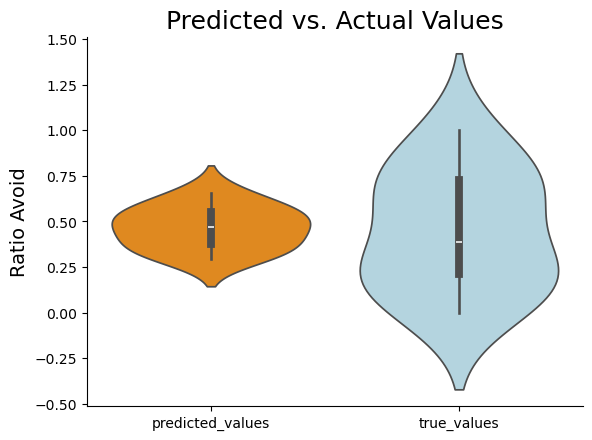

In [199]:
fig, ax = plt.subplots()
sns.violinplot(data=testing_df, x='inference_cat', y='ratio_avoid', hue='inference_cat', palette=['darkorange', 'lightblue'], ax = ax)




ax.set_xlabel('', fontsize=10)
ax.set_ylabel('Ratio Avoid', fontsize=14)
ax.set_title('Predicted vs. Actual Values', fontsize = 18)
sns.despine()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Text(0.5, 1.0, 'Feature Importance')

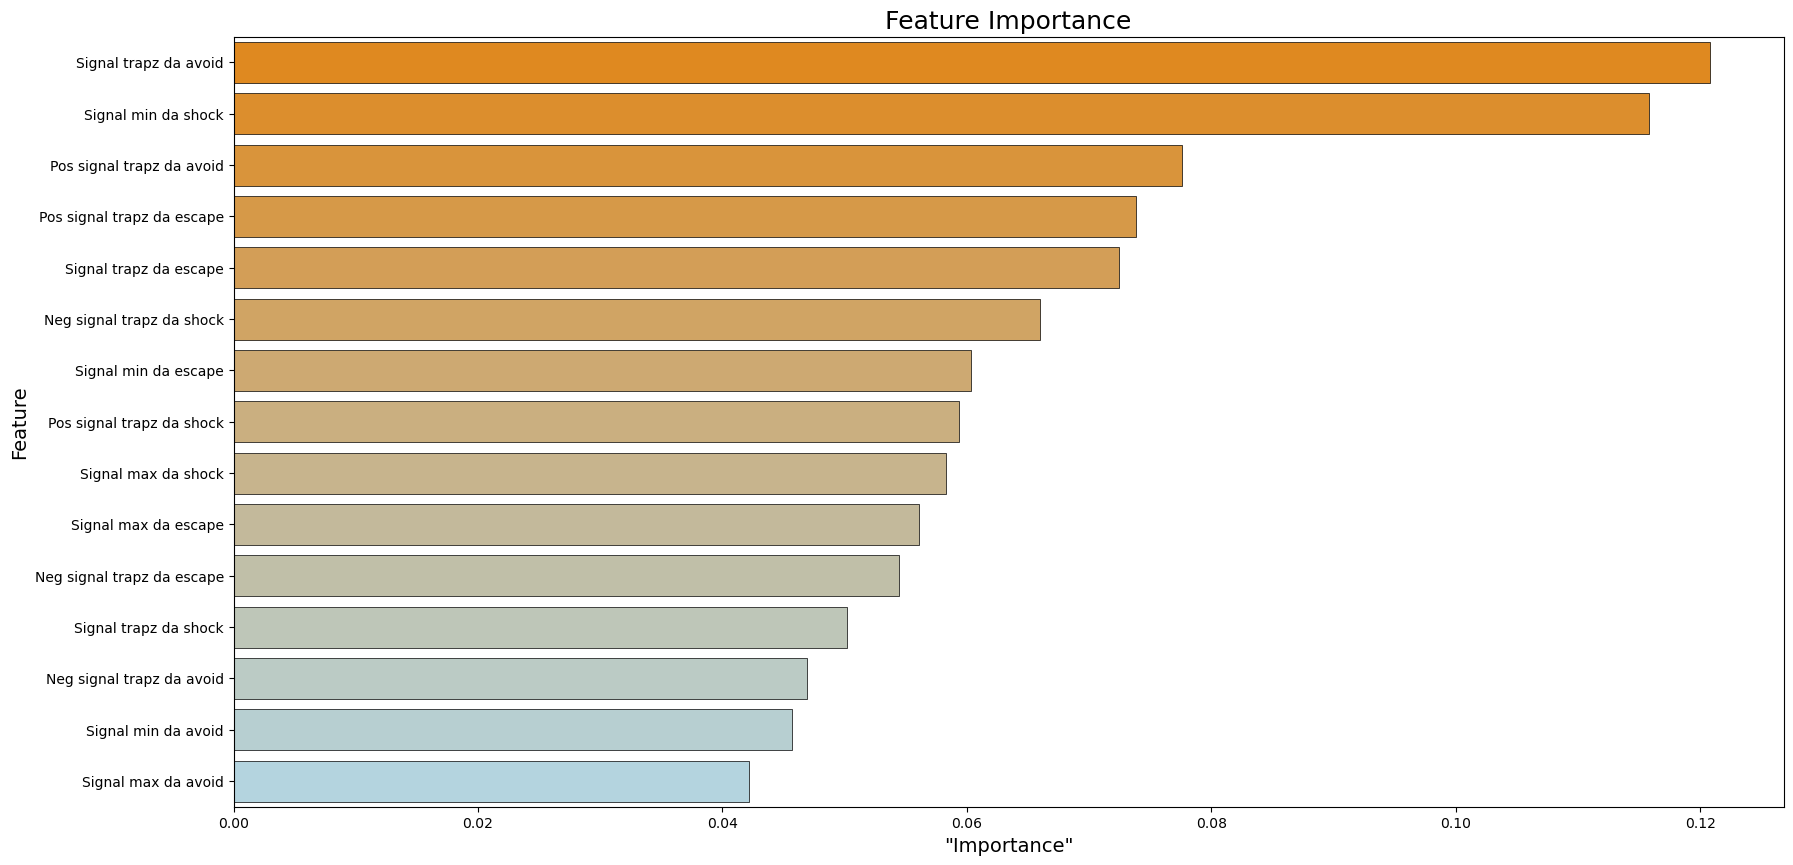

In [203]:
from matplotlib.colors import LinearSegmentedColormap


cols = get_cols_from_pipeline(NO_CUE_PIPE)
# cols_new = [col.removeprefix("sensor_event_variable_") for col in cols]
feature_importance = (
    pd.Series(
    no_cue_model.feature_importances_, index = cols)
    .sort_values(ascending=False)
)
color_map = LinearSegmentedColormap.from_list("orange_blue",["#FF8C00","#ADD8E6"])
colors = [color_map(i) for i in np.linspace(0, 1, len(feature_importance))]

# feature_importance
col_labels = [col.capitalize().replace('_', ' ') for col in feature_importance.index]
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x=feature_importance, y=feature_importance.index, ax=ax, linewidth=0.5, palette=colors, edgecolor='black')
ax.set_yticklabels(col_labels)
# ax.set_xscale("log")
ax.set_xlabel('"Importance"', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Feature Importance', fontsize = 18)